## Μέρος 2: Εντοπισμός Χωρο-χρονικών Σημείων Ενδιαφέροντος και Εξαγωγή Χαρακτηριστικών σε Βίντεο Ανθρωπίνων Δράσεων

### 2.1 Χωρο-χρονικά Σημεία Ενδιαφέροντος 

In [1]:
import cv24_lab2_2_utils as utils2
from scipy.ndimage import convolve1d
from scipy import signal
from scipy import ndimage as nd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2
import os
from tqdm import tqdm
%matplotlib inline

In [2]:
#Reading files name
walk_videos = listdir('./cv24_lab2_part2/cv24_lab2_part2/walking/')
run_videos = listdir('./cv24_lab2_part2/cv24_lab2_part2/running/')
box_videos = listdir('./cv24_lab2_part2/cv24_lab2_part2/boxing/')

#conneting file name to path
for i in range (16):
    walk_videos[i] = './cv24_lab2_part2/cv24_lab2_part2/walking/' + walk_videos[i]
    run_videos[i] = './cv24_lab2_part2/cv24_lab2_part2/running/' + run_videos[i]
    box_videos[i] = './cv24_lab2_part2/cv24_lab2_part2/boxing/' + box_videos[i]

print("There are", str(len(walk_videos)), "videos for walking,", str(len(run_videos)), \
      "videos for running and", str(len(box_videos)), "videos for boxing.")

There are 16 videos for walking, 16 videos for running and 16 videos for boxing.


In [3]:
#Importing 1 video from each catecory
walk_video1 = utils2.read_video(walk_videos[3],20,0)
run_video1 = utils2.read_video(run_videos[3],20,0)
box_video1 = utils2.read_video(box_videos[3],20,0)

print(walk_video1.shape)
print(run_video1.shape)
print(box_video1.shape)

(120, 160, 20)
(120, 160, 20)
(120, 160, 20)


In [4]:
#2.1.1 Υλοποίηση ανιχνευτή Harris-Stephens
########################################################

def harrisDetector3D(video,sigma,t,scale,k):
    #Δημιουργία γκαουσιανού πυρήνα ομαλοποίησης
    ns = int(2*np.ceil(3*sigma)+1)
    nt = int(2*np.ceil(3*t)+1)
    #Χωρική κλίμακα
    Gs = cv2.getGaussianKernel(ns,sigma)
    Gs = Gs.reshape(Gs.shape[0])## necessary for convolve1d
    #Χρονική κλίμακα
    Gt = cv2.getGaussianKernel(nt,t)
    Gt = Gt.reshape(Gt.shape[0])
    
    #Apply Gs on axis=0,1 (x,y) and Gt on axis=2 (t)
    smoothed_vid = convolve1d(convolve1d(convolve1d(video,Gs,axis=0),Gs,axis=1),Gt,axis=2)
    
    #Χωροχρονικές παραγώγοι 
    Ly,Lx,Lt = np.gradient(smoothed_vid)
    
    scaled_ns = int(2*np.ceil(3*scale*sigma))+1
    scaled_nt = int(2*np.ceil(3*scale*t)+1)
    scaled_Gs = cv2.getGaussianKernel(scaled_ns,scale*sigma)
    scaled_Gs = scaled_Gs.reshape(scaled_Gs.shape[0])
    scaled_Gt = cv2.getGaussianKernel(scaled_nt,scale*t)  
    scaled_Gt = scaled_Gt.reshape(scaled_Gt.shape[0])
    
    #Calculation of the M(x,y,t) matrix for each voxel
    M11 = convolve1d(convolve1d(convolve1d(Lx**2,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)
    M12 = convolve1d(convolve1d(convolve1d(Lx*Ly,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)
    M13 = convolve1d(convolve1d(convolve1d(Lx*Lt,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)  
    M21 = convolve1d(convolve1d(convolve1d(Lx*Ly,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)
    M22 = convolve1d(convolve1d(convolve1d(Ly**2,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)
    M23 = convolve1d(convolve1d(convolve1d(Ly*Lt,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)
    M31 = convolve1d(convolve1d(convolve1d(Lx*Lt,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)    
    M32 = convolve1d(convolve1d(convolve1d(Ly*Lt,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)
    M33 = convolve1d(convolve1d(convolve1d(Lt**2,scaled_Gs,axis=0),scaled_Gs,axis=1),scaled_Gt,axis=2)
        
    #Εφαρμογή του κριτηρίου γωνιότητας
    #H(x, y, t) = det(M(x, y, t)) − k · trace^3(M(x, y, t))
    detM = M11*(M22*M33-M23*M31)-M12*(M21*M33-M23*M31)+M13*(M21*M32-M22*M31)
    traceM = M11+M22+M33
    H = detM - k*(traceM)**3
    
    #2.1.3  Απόρριψη σημείων που αντιστοιχούν σε σχετικά ομαλές περιοχές
    Cond = (H >= 0.1*H.max()).astype(int)
    H = H*Cond
    
    y, x, t = np.unravel_index(np.argsort(-1*H, axis=None), H.shape)
    scale = sigma*np.ones(x.shape)
    points = list(zip(x,y,t,scale))
    
    return np.array(points[:600])

In [35]:
#Ενδεικτικές τιμές παραμέτρων
points_walk = harrisDetector3D(walk_video1,4,1.5,2,0.005)
points_run = harrisDetector3D(run_video1,4,1.5,2,0.005)
points_box = harrisDetector3D(box_video1,4,1.5,2,0.005)

In [36]:
#Τesting harrisDetector3D for walking/running/boxing
utils2.show_detection(walk_video1,points_walk, save_path = './HarrisStephens/walking/')
utils2.show_detection(run_video1,points_run, save_path = './HarrisStephens/running/')
utils2.show_detection(box_video1,points_box, save_path = './HarrisStephens/boxing/')

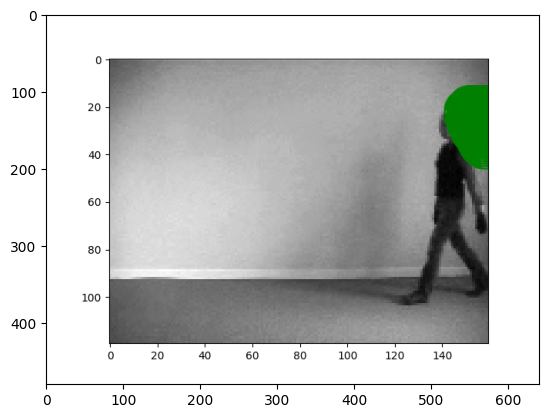

In [37]:
f1 = cv2.imread(f"./HarrisStephens/walking/frame19.png")
plt.imshow(f1)

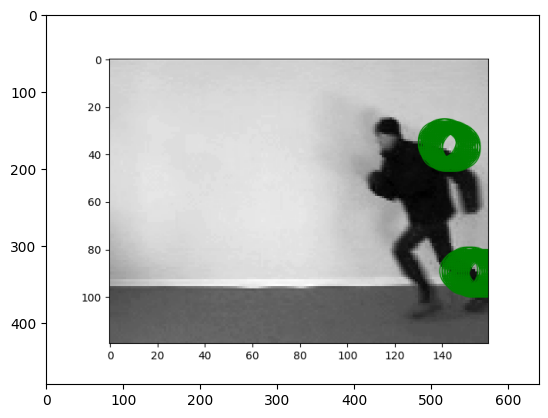

In [38]:
f2 = cv2.imread(f"./HarrisStephens/running/frame17.png")
plt.imshow(f2)

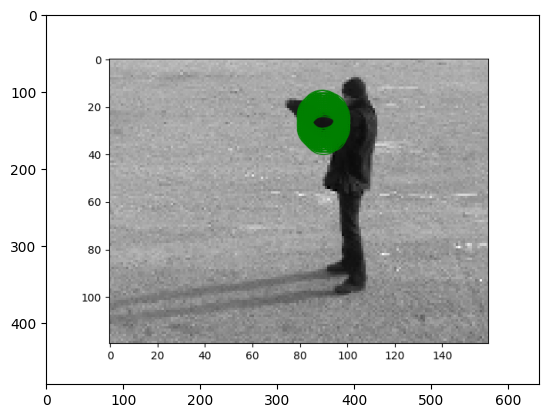

In [39]:
f3= cv2.imread(f"./HarrisStephens/boxing/frame17.png")
plt.imshow(f3)

In [10]:
#2.1.1 Υλοποίηση ανιχνευτή Gabor
########################################################

def Gabor(video,sigma,t):
    ns = int(2*np.ceil(3*sigma)+1)
    Gs = cv2.getGaussianKernel(ns,sigma)
    Gs = Gs.reshape(Gs.shape[0])
    
    time = np.linspace(-2*t,2*t,int(4*t+1))
    omega = 4/t
    
    #Create hev, hod
    h_ev = (np.cos(2*np.pi*time*omega)*np.exp(-time**2/(2*t**2)))
    h_od = (np.sin(2*np.pi*time*omega)*np.exp(-time**2/(2*t**2)))
    
    #Normalization 
    h_ev = h_ev/np.linalg.norm(h_ev,ord=1)
    h_od = h_od/np.linalg.norm(h_od,ord=1)
    
    #Εφαρμογή κριτηρίου γωνιότητας
    Iev = convolve1d(convolve1d(convolve1d(video,Gs,axis=0),Gs,axis=1),h_ev,axis=2)
    Iod = convolve1d(convolve1d(convolve1d(video,Gs,axis=0),Gs,axis=1),h_od,axis=2)
    #H(x, y, t) = (I(x, y, t) ∗ g ∗ hev)^2 + (I(x, y, t) ∗ g ∗ hod)^2
    H = Iev**2 + Iod**2
    
    #2.1.3  Απόρριψη σημείων που αντιστοιχούν σε σχετικά ομαλές περιοχές
    Cond = (H >= 0.25*H.max()).astype(int)
    H = H*Cond
    
    y, x, t = np.unravel_index(np.argsort(-1*H, axis=None), H.shape)
    scale = sigma*np.ones(x.shape)
    points = list(zip(x,y,t,scale))
    
    return np.array(points[:600])

In [41]:
#Ενδεικτικές τιμές παραμέτρων
points_walk = Gabor(walk_video1,4,1.5)
points_run = Gabor(run_video1,4,1.5)
points_box = Gabor(box_video1,4,1.5)


In [42]:
#Τesting GaborDetector for walking/running/boxing
utils2.show_detection(walk_video1,points_walk, save_path = './Gabor/walking/')
utils2.show_detection(run_video1,points_run, save_path = './Gabor/running/')
utils2.show_detection(box_video1,points_box, save_path = './Gabor/boxing/')

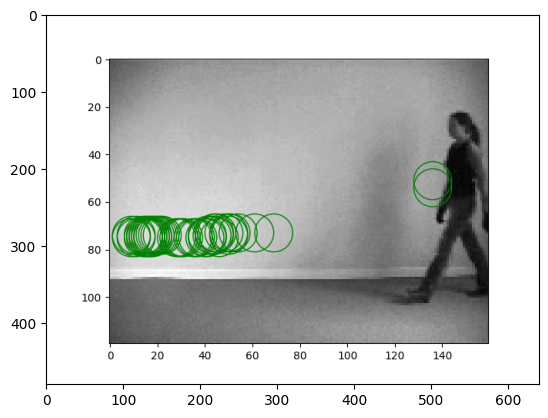

In [43]:
f1 = cv2.imread("./Gabor/walking/frame17.png")
plt.imshow(f1)

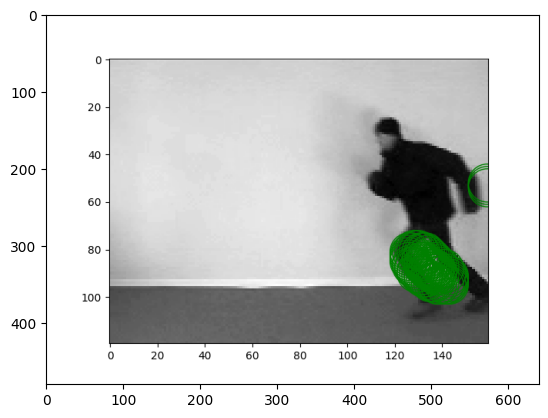

In [44]:
f2 = cv2.imread("./Gabor/running/frame17.png")
plt.imshow(f2)

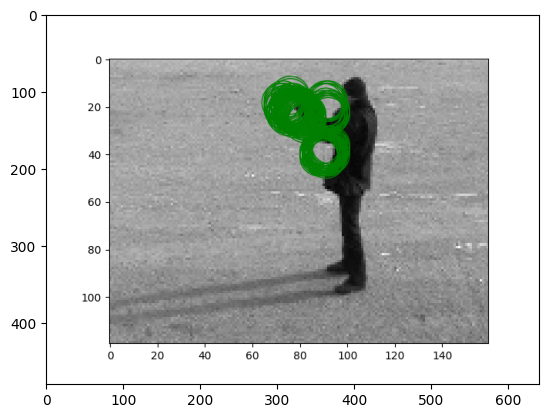

In [45]:
f3= cv2.imread(f"./Gabor/boxing/frame18.png")
plt.imshow(f3)

### 2.2 Χωρο-χρονικοί Ιστογραφικοί Περιγραφητές

In [6]:
#Each frame has 120x160 pixel 
#We are making a boolean function to tell if we are not out of the border out(feat)=True ==> we are OUTSIDE
def out(feat):
    sigma = feat[3]
    return ((feat[1]-sigma//2)<0) or ((feat[1]+sigma//2)>120) or ((feat[0]-sigma//2)<0) or ((feat[0]+sigma//2)>160)

#2.2.1 Making descriptors HOF ,HOG  and HOG/HOF
def hist_desc(video,feats,desc_type,nbins):
    
    '''
    According to selected method, isolate an (sigma x sigma) area around feature point
    and calculate the histogram of this area (a histrographic distription of the area)
    
    HOG: this area contains information about the spatial gradient
    HOF: this area contains information about the optical flow
    
    video: number of pixels per frame (x,y) x t
    feats: the extracted features of HarrisDetector/Gabor
    desc_type: the type of the descriptor we want to use
               desc_type='HOG' || desc_type='HOF'  || desc_type='HOG/HOF' 
    nbins: number of bins for the histogram
    
    '''
    result = []
    #HOG 
    if desc_type == 'HOG' or desc_type=='HOG/HOF':
        vy,vx,vt = np.gradient(video)
        #For each feature
        for feat in feats:
            #If we are inside the border
            if not out(feat):
                sigma = int(feat[3])
                ## pick all points +-sigma/2 from a feature point detected in time t
                Gx = vx[int(feat[1]-sigma//2):int(feat[1]+sigma//2),int(feat[0]-sigma//2):int(feat[0]+sigma//2),int(feat[2])]
                Gy = vy[int(feat[1]-sigma//2):int(feat[1]+sigma//2),int(feat[0]-sigma//2):int(feat[0]+sigma//2),int(feat[2])]
                desc = utils2.orientation_histogram(Gx,Gy,nbins,np.array([sigma,sigma]))
                result.append(desc)
    #HOF
    if desc_type == 'HOF' or desc_type == 'HOG/HOF':
        opt_flow = cv2.DualTVL1OpticalFlow_create()
        #Find the flow between all the pairs of frames --> dx,dy 3D arrays
        dx = []
        dy = []
        for i in range(video.shape[2]-1):
            frame1 = (video[:,:,i].astype(np.uint8))*241
            frame2 = (video[:,:,i+1].astype(np.uint8))*241
            flow = opt_flow.calc(frame1,frame2,None)
            dx.append(flow[:,:,1])
            dy.append(flow[:,:,0])
        #For every feature extraxt an (sigma x sigma) area around it
        for feat in feats:
            #If we are inside the border and not in the last frame
            if not out(feat) and feat[2]!=199:
                sigma = int(feat[3])
                ## pick all points +-sigma/2 from a feature point detected in time t
                Gx = dx[int(feat[2])][int(feat[1]-sigma//2):int(feat[1]+sigma//2),int(feat[0]-sigma//2):int(feat[0]+sigma//2)]
                Gy = dy[int(feat[2])][int(feat[1]-sigma//2):int(feat[1]+sigma//2),int(feat[0]-sigma//2):int(feat[0]+sigma//2)]
                desc = utils2.orientation_histogram(Gx,Gy,nbins,np.array([sigma,sigma]))
                result.append(desc)
                
    return np.array(result)

### 2.3: Κατασκευή Bag of Visual Words και χρήση Support Vector Machines για την ταξινόμηση δράσεων 

In [7]:
#2.3.1 Seperating videos into test and train sets as the traininng_videos.txt describes

training_videos_txt = open('./cv24_lab2_part2/cv24_lab2_part2/traininng_set.txt', 'r')
training_videos_names = training_videos_txt.readlines()

training_videos = []
test_videos = []
training_labels= []
test_labels= []
test_videos_name = []

#Training and test set from walking folder
for name in listdir('./cv24_lab2_part2/cv24_lab2_part2/walking/'):
    #print('./walking/' + name)
    if name + '\n' in training_videos_names:
        vid = utils2.read_video('./cv24_lab2_part2/cv24_lab2_part2/walking/' + name , 200)
        training_videos.append(vid)
        training_labels.append('walk')
    else:
        vid = utils2.read_video('./cv24_lab2_part2/cv24_lab2_part2/walking/' + name , 200)
        test_videos.append(vid)
        test_labels.append('walk')
        test_videos_name.append(name)

#Training and test set from boxing folder      
for name in listdir('./cv24_lab2_part2/cv24_lab2_part2/boxing/'):
    if name + '\n' in training_videos_names:
        vid = utils2.read_video('./cv24_lab2_part2/cv24_lab2_part2/boxing/' + name , 200)
        training_videos.append(vid)
        training_labels.append('box')
    else:
        vid = utils2.read_video('./cv24_lab2_part2/cv24_lab2_part2/boxing/' + name , 200)
        test_videos.append(vid)
        test_labels.append('box')
        test_videos_name.append(name)

#Training and test set from running folder    
for name in listdir('./cv24_lab2_part2/cv24_lab2_part2/running/'):
    if name + '\n' in training_videos_names:
        vid = utils2.read_video('./cv24_lab2_part2/cv24_lab2_part2/running/' + name , 200)
        training_videos.append(vid)
        training_labels.append('run')
    else:
        vid = utils2.read_video('./cv24_lab2_part2/cv24_lab2_part2/running/' + name , 200)
        test_videos.append(vid)
        test_labels.append('run')
        test_videos_name.append(name)

#print(len(test_videos),len(test_labels))
#print(len(training_videos),len(training_labels))

In [11]:
#2.3.2 and 2.3.3 Τελική αναπαράσταση και τελική κατηγοριοποίηση των εικόνων 
# Δοκιμάζουμε για ανιχνευτές HarrisDetector και Gabor 
# Δοκιμάζουμε για περιγραφητές HOG,HOF , HOG/HOF
# Σύνολο: 6 συνδυασμοί

###############################
# 1) HarrisDetector/HOG
##################################

#Θα αποθηκεύσουμε τα σημεία ενδιαφέροντος που βρίσκονται με τον ανιχνευτή σε μια λίστα για να κερδίσουμε χρόνο 
interest_Harris_points_training = []
desc_HOG_Harris_train = []
for video in  tqdm(training_videos):
    interest_points = harrisDetector3D(video,4,1.5,2,0.005)
    interest_Harris_points_training.append(interest_points)
    desc = hist_desc(video, interest_points,'HOG',9)
    desc_HOG_Harris_train.append(desc)
#Θα αποθηκεύσουμε τα σημεία ενδιαφέροντος που βρίσκονται με τον ανιχνευτή σε μια λίστα για να κερδίσουμε χρόνο 
interest_Harris_points_test = []
desc_HOG_Harris_test = []
for video in tqdm(test_videos):
    interest_points = harrisDetector3D(video,4,1.5,2,0.005)
    interest_Harris_points_test.append(interest_points)
    desc = hist_desc(video, interest_points,'HOG',9)
    desc_HOG_Harris_test.append(desc)
#Bag of Words for Harris/HOG
bow_train_HOG_Harris, bow_test_HOG_Harris = utils2.bag_of_words(desc_HOG_Harris_train, desc_HOG_Harris_test, 400)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.85s/it]


In [12]:
#Aποτελέσματα HarrisDetector/HOG 
combo = 'Detector:\tHarris \nDescriptor:\tHOG'
accuracy, pred = utils2.svm_train_test(bow_train_HOG_Harris, training_labels,bow_test_HOG_Harris, test_labels)
print('\033[1m' + combo + '\033[0m')
print()
print('The accuracy for the combination is ' + str(format(accuracy*100, ".3f")) + "%")
print()
print("Results:")
print()
k = test_videos_name
a = test_labels
b = pred
c = a == b
print("Video Name \t \t \t Correct Prediction")

for i in range(len(a)):
    print(k[i] + '\t ' + a[i] + '\t ' + b[i]+ '\t ' + str(c[i]))

Detector:	Harris 
Descriptor:	HOG

The accuracy for the combination is 75.000%

Results:

Video Name 	 	 	 Correct Prediction
person07_walking_d4_uncomp.avi	 walk	 walk	 True
person08_walking_d2_uncomp.avi	 walk	 walk	 True
person11_walking_d1_uncomp.avi	 walk	 walk	 True
person20_walking_d3_uncomp.avi	 walk	 run	 False
person06_boxing_d1_uncomp.avi	 box	 box	 True
person07_boxing_d3_uncomp.avi	 box	 box	 True
person11_boxing_d2_uncomp.avi	 box	 box	 True
person15_boxing_d4_uncomp.avi	 box	 walk	 False
person10_running_d2_uncomp.avi	 run	 run	 True
person20_running_d1_uncomp.avi	 run	 run	 True
person24_running_d3_uncomp.avi	 run	 run	 True
person25_running_d4_uncomp.avi	 run	 walk	 False


In [ ]:
###############################
# 2) HarrisDetector/HOF
##################################

desc_HOF_Harris_train = []
desc_HOF_Harris_test = []
i=0
for video in  tqdm(training_videos):
    desc = hist_desc(video, interest_Harris_points_training[i],'HOF',9)
    desc_HOF_Harris_train.append(desc)
    i +=1

i=0
for video in tqdm(test_videos):
    desc = hist_desc(video, interest_Harris_points_test[i],'HOF',9)
    desc_HOF_Harris_test.append(desc)
#Bag of Words for Harris/HOF
bow_train_HOF_Harris, bow_test_HOF_Harris = utils2.bag_of_words(desc_HOF_Harris_train, desc_HOF_Harris_test, 400)

 11%|████████▉                                                                       | 4/36 [08:48<1:13:36, 138.01s/it]

In [ ]:
#Aποτελέσματα HarrisDetector/HOF
combo = 'Detector:\tHarris \nDescriptor:\tHOF'
accuracy, pred = utils2.svm_train_test(bow_train_HOF_Harris, training_labels,bow_test_HOF_Harris, test_labels)
print('\033[1m' + combo + '\033[0m')
print()
print('The accuracy for the combination is ' + str(format(accuracy*100, ".3f")) + "%")
print()
print("Results:")
print()
k = test_videos_name
a = test_labels
b = pred
c = a == b
print("Video Name \t \t \t Correct Prediction")

for i in range(len(a)):
    print(k[i] + '\t ' + a[i] + '\t ' + b[i]+ '\t ' + str(c[i]))

In [ ]:
###############################
# 3) HarrisDetector/ HOG_HOF
##################################
desc_HOF_HOG_Harris_train = []
desc_HOF_HOG_Harris_test = []
i=0
for video in  tqdm(training_videos):
    desc = hist_desc(video, interest_Harris_points_training[i],'HOG/HOF',9)
    desc_HOF_HOG_Harris_train.append(desc)
    i +=1

i=0
for video in tqdm(test_videos):
    desc = hist_desc(video, interest_Harris_points_test[i],'HOG/HOF',9)
    desc_HOF_HOG_Harris_test.append(desc)
#Bag of Words for Harris/HOF
bow_train_HOF_HOG_Harris, bow_test_HOF_HOG_Harris = utils2.bag_of_words(desc_HOF_HOG_Harris_train, desc_HOF_HOG_Harris_test, 400)

In [ ]:
#Aποτελέσματα HarrisDetector/HOG_HOF
combo = 'Detector:\tHarris \nDescriptor:\tHOG_HOF'
accuracy, pred = utils2.svm_train_test(bow_train_HOF_HOG_Harris, training_labels,bow_test_HOF_HOG_Harris, test_labels)
print('\033[1m' + combo + '\033[0m')
print()
print('The accuracy for the combination is ' + str(format(accuracy*100, ".3f")) + "%")
print()
print("Results:")
print()
k = test_videos_name
a = test_labels
b = pred
c = a == b
print("Video Name \t \t \t Correct Prediction")

for i in range(len(a)):
    print(k[i] + '\t ' + a[i] + '\t ' + b[i]+ '\t ' + str(c[i]))

In [50]:
###############################
# 4) Gabor/HOG
##################################

#Θα αποθηκεύσουμε τα σημεία ενδιαφέροντος που βρίσκονται με τον ανιχνευτή σε μια λίστα για να κερδίσουμε χρόνο 
interest_Gabor_points_training = []
desc_HOG_Gabor_train = []
for video in  tqdm(training_videos):
    interest_points = Gabor(video,4,1.5)
    interest_Gabor_points_training.append(interest_points)
    desc = hist_desc(video, interest_points,'HOG',9)
    desc_HOG_Gabor_train.append(desc)
#Θα αποθηκεύσουμε τα σημεία ενδιαφέροντος που βρίσκονται με τον ανιχνευτή σε μια λίστα για να κερδίσουμε χρόνο 
interest_Gabor_points_test = []
desc_HOG_Gabor_test = []
for video in tqdm(test_videos):
    interest_points = Gabor(video,4,1.5)
    interest_Gabor_points_test.append(interest_points)
    desc = hist_desc(video, interest_points,'HOG',9)
    desc_HOG_Gabor_test.append(desc)
#Bag of Words for Gabor/HOG
bow_train_HOG_Gabor, bow_test_HOG_Gabor = utils2.bag_of_words(desc_HOG_Gabor_train, desc_HOG_Gabor_test, 400)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.56s/it]


In [51]:
combo = 'Detector:\tGabor \nDescriptor:\tHOG'
accuracy, pred = utils2.svm_train_test(bow_train_HOG_Gabor, training_labels,bow_test_HOG_Gabor, test_labels)
print('\033[1m' + combo + '\033[0m')
print()
print('The accuracy for the combination is ' + str(format(accuracy*100, ".3f")) + "%")
print()
print("Results:")
print()
k = test_videos_name
a = test_labels
b = pred
c = a == b
print("Video Name \t \t \t Correct Prediction")

for i in range(len(a)):
    print(k[i] + '\t ' + a[i] + '\t ' + b[i]+ '\t ' + str(c[i]))

Detector:	Gabor 
Descriptor:	HOG

The accuracy for the combination is 58.333%

Results:

Video Name 	 	 	 Correct Prediction
person07_walking_d4_uncomp.avi	 walk	 walk	 True
person08_walking_d2_uncomp.avi	 walk	 box	 False
person11_walking_d1_uncomp.avi	 walk	 run	 False
person20_walking_d3_uncomp.avi	 walk	 run	 False
person06_boxing_d1_uncomp.avi	 box	 box	 True
person07_boxing_d3_uncomp.avi	 box	 run	 False
person11_boxing_d2_uncomp.avi	 box	 box	 True
person15_boxing_d4_uncomp.avi	 box	 walk	 False
person10_running_d2_uncomp.avi	 run	 run	 True
person20_running_d1_uncomp.avi	 run	 run	 True
person24_running_d3_uncomp.avi	 run	 run	 True
person25_running_d4_uncomp.avi	 run	 run	 True


In [ ]:
###############################
# 5) Gabor/HOF
##################################
desc_HOF_Gabor_train = []
desc_HOF_Gabor_test = []
i=0
for video in  tqdm(training_videos):
    desc = hist_desc(video, interest_Gabor_points_training[i],'HOF',9)
    desc_HOF_Gabor_train.append(desc)
    i +=1

i=0
for video in tqdm(test_videos):
    desc = hist_desc(video, interest_Gabor_points_test[i],'HOF',9)
    desc_HOF_Gabor_test.append(desc)
#Bag of Words for Gabor/HOF
bow_train_HOF_Gabor, bow_test_HOF_Gabor = utils2.bag_of_words(desc_HOF_Gabor_train, desc_HOF_Gabor_test, 50)

In [ ]:
#Aποτελέσματα Gabor/HOF
combo = 'Detector:\tGabor \nDescriptor:\tHOF'
accuracy, pred = utils2.svm_train_test(bow_train_HOF_Gabor, training_labels,bow_test_HOF_Gabor, test_labels)
print('\033[1m' + combo + '\033[0m')
print()
print('The accuracy for the combination is ' + str(format(accuracy*100, ".3f")) + "%")
print()
print("Results:")
print()
k = test_videos_name
a = test_labels
b = pred
c = a == b
print("Video Name \t \t \t Correct Prediction")

for i in range(len(a)):
    print(k[i] + '\t ' + a[i] + '\t ' + b[i]+ '\t ' + str(c[i]))

In [ ]:
###############################
# 6) Gabor/ HOG_HOF
##################################
desc_HOF_HOG_Gabor_train = []
desc_HOF_HOG_Gabor_test = []
i=0
for video in  tqdm(training_videos):
    desc = hist_desc(video, interest_Gabor_points_training[i],'HOG/HOF',9)
    desc_HOF_HOG_Gabor_train.append(desc)
    i +=1

i=0
for video in tqdm(test_videos):
    desc = hist_desc(video, interest_Gabor_points_test[i],'HOG/HOF',9)
    desc_HOF_HOG_Gabor_test.append(desc)
#Bag of Words for Gabor/HOF_HOG
bow_train_HOF_HOG_Gabor, bow_test_HOF_HOG_Gabor = utils2.bag_of_words(desc_HOF_HOG_Gabor_train, desc_HOF_HOG_Gabor_test, 400)

In [ ]:
#Aποτελέσματα Gabor/HOG_HOF
combo = 'Detector:\tGabor \nDescriptor:\tHOG_HOF'
accuracy, pred = utils2.svm_train_test(bow_train_HOF_HOG_Gabor, training_labels,bow_test_HOF_HOG_Gabor, test_labels)
print('\033[1m' + combo + '\033[0m')
print()
print('The accuracy for the combination is ' + str(format(accuracy*100, ".3f")) + "%")
print()
print("Results:")
print()
k = test_videos_name
a = test_labels
b = pred
c = a == b
print("Video Name \t \t \t Correct Prediction")

for i in range(len(a)):
    print(k[i] + '\t ' + a[i] + '\t ' + b[i]+ '\t ' + str(c[i]))